## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

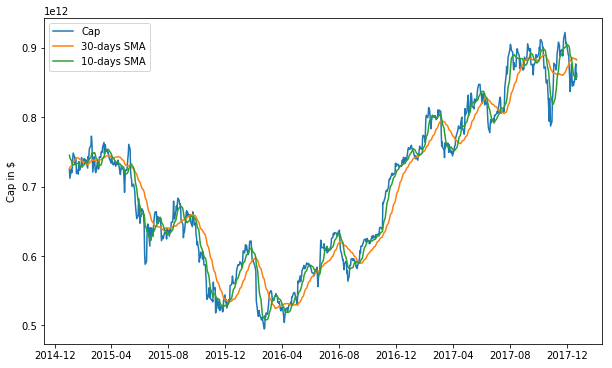

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [7]:
# Put the rest of you code and analysis for Part I here 

## Data Preprocessing

In [8]:
# Taking logarithm of market cap values

df_log_cap = df_cap.applymap(np.log)

In [9]:
# Moving Averages

short_rolling_log_cap = df_log_cap.rolling(window=window_1).mean()
long_rolling_log_cap = df_log_cap.rolling(window=window_2).mean()

ewma_short_rolling_log_cap = df_log_cap.ewm(span=window_1, adjust=False).mean()
ewma_long_rolling_log_cap = df_log_cap.ewm(span=window_2, adjust=False).mean()

In [10]:
# Rescaling

average_log_market_cap = df_log_cap.mean(axis=0)

df_log_cap_rescaled = df_log_cap / average_log_market_cap
short_rolling_log_cap_rescaled = short_rolling_log_cap / average_log_market_cap
long_rolling_log_cap_rescaled = long_rolling_log_cap / average_log_market_cap
ewma_short_rolling_log_cap_rescaled = ewma_short_rolling_log_cap / average_log_market_cap
ewma_long_rolling_log_cap_rescaled = ewma_long_rolling_log_cap / average_log_market_cap

In [11]:
# Calculating Pct Change

short_rolling_log_cap_pct_change = short_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
long_rolling_log_cap_pct_change = long_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
ewma_short_rolling_log_cap_pct_change = ewma_short_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
ewma_long_rolling_log_cap_pct_change = ewma_long_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)

In [12]:
# Log Market Cap
log_market_cap = df_log_cap_rescaled.copy()
log_market_cap_next = df_log_cap_rescaled.shift(-1).dropna()

# Signals
signal_log_cap_1 = short_rolling_log_cap_pct_change.dropna()
signal_log_cap_2 = long_rolling_log_cap_pct_change.dropna()
signal_log_cap_3 = ewma_short_rolling_log_cap_pct_change.dropna()
signal_log_cap_4 = ewma_long_rolling_log_cap_pct_change.dropna()

# Get rid rows where dates that do not match
index4 = log_market_cap.index\
    .intersection(log_market_cap_next.index)\
    .intersection(signal_log_cap_1.index)\
    .intersection(signal_log_cap_2.index)\
    .intersection(signal_log_cap_3.index)\
    .intersection(signal_log_cap_4.index)

log_market_cap = log_market_cap.loc[index4]
log_market_cap_next = log_market_cap_next.loc[index4]
signal_log_cap_1 = signal_log_cap_1.loc[index4]
signal_log_cap_2 = signal_log_cap_2.loc[index4]
signal_log_cap_3 = signal_log_cap_3.loc[index4]
signal_log_cap_4 = signal_log_cap_4.loc[index4]

## Fitting

In [13]:
class CalibrationModel:
    """
    class CalibrationModel - implements maximum likelihood estimator (MLE) solution
    """
    def __init__(self, n_features, n_signals, learning_rate=0.05, sameWeights=True, lamda=1e1):
        # input placeholders
        self.Y_t = tf.placeholder(tf.float32, [None, n_features], name="Y_t") 
        self.Y_tplus1 = tf.placeholder(tf.float32, [None, n_features], name="Y_tplus1")
        self.Z = tf.placeholder(tf.float32, [None, n_signals], name="Z")
        
        # Augmented signals matrix is obtained by adding a column of ones to the data matrix
        signals_plus_bias = tf.concat([tf.ones([tf.shape(self.Z)[0], 1]), self.Z], axis=1)
        
        # Estimate the model using the Maximum Likelihood Estimation (MLE)
        
        assert n_signals%n_features==0
        n_signal_types = n_signals//n_features
        
        tf.set_random_seed(97)
        
        # regression parameters for the Maximum Likelihood method
        if sameWeights:
            #self.theta = tf.Variable(tf.random_normal([1]), name="theta")
            #self.k = tf.Variable(tf.random_normal([1]), name="k")
            #self.g = tf.Variable(tf.random_normal([1]), name="g")
            #self.w = tf.Variable(tf.random_normal([n_signal_types]), name="w")
            #self.w = tf.Variable(tf.random_normal([1+n_signal_types]), name="w")
            #self.std = tf.Variable(tf.random_uniform([1], minval=0.01, maxval=0.05), name="std")
            self.theta = tf.Variable(-.01, name="theta", 
                                     constraint=lambda x: tf.clip_by_value(x, -np.inf, 0.))
#             self.k = tf.Variable(-.01, name="k", 
#                                  constraint=lambda x: tf.clip_by_value(x, -np.inf, 0.))
            self.g = tf.Variable(.01, name="g", 
                                 constraint=lambda x: tf.clip_by_value(x, 0., np.inf))
            #self.w = tf.Variable((1/max(n_signal_types, 1))*tf.ones([n_signal_types]), name="w")
            self.w = tf.Variable((1/(1+n_signal_types))*tf.ones([1+n_signal_types]), name="w")
            self.std = tf.Variable(0.01, name="std", 
                                   constraint=lambda x: tf.clip_by_value(x, 0., np.inf))
#             self.k = tf.Variable(-.01, name="k", 
#                                  constraint=lambda x: tf.clip_by_value(x, -np.inf, 
#                                                                        -2*tf.sqrt(self.g*tf.abs(self.theta-.5*self.std**2))))
            self.Theta = tf.multiply(self.theta, tf.ones([1, n_features]), name="Theta")
#             self.K = tf.multiply(self.k, tf.ones([1, n_features]), name="K")
            self.G = tf.multiply(self.g, tf.ones([1, n_features]), name="G")
            self.W = tf.concat( (
                # [ tf.ones([1, n_features]), ] + 
                [ self.w[0] * tf.ones([1, n_features]), ] + 
                # [ self.w[i] * tf.eye(n_features) for i in range(n_signal_types) ]
                [ self.w[i+1] * tf.eye(n_features) for i in range(n_signal_types) ]
            ), axis = 0, name="W" )
            self.sigma_diag = tf.multiply( self.std, tf.ones([1, n_features]), name="sigma_diag")
        else:
            #self.Theta = tf.Variable(.01*tf.random_normal([1, n_features]), name="Theta")
            #self.K = tf.Variable(.01*tf.random_normal([1, n_features]), name="K")
            #self.G = tf.Variable(.01*tf.random_normal([1, n_features]), name="G")
            #w = tf.Variable((1/max(n_signal_types, 1))*tf.random_normal([n_signals]), name="w")
            #w = tf.Variable((1/(1+n_signal_types))*tf.random_normal([n_features+n_signals]), name="w")
            self.Theta = tf.Variable(-.01*tf.ones([1, n_features]), name="Theta", 
                                     constraint=lambda x: tf.clip_by_value(x, -np.inf, 0.))
#             self.K = tf.Variable(-.01*tf.ones([1, n_features]), name="K", 
#                                  constraint=lambda x: tf.clip_by_value(x, -np.inf, 0.))
            self.G = tf.Variable(.01*tf.ones([1, n_features]), name="G", 
                                 constraint=lambda x: tf.clip_by_value(x, 0., np.inf))
            #w = tf.Variable((1/max(n_signal_types, 1))*tf.ones([n_signals]), name="w")
            w = tf.Variable((1/(1+n_signal_types))*tf.ones([n_features+n_signals]), name="w")
            self.W = tf.concat((
                # [ tf.ones([1, n_features]), ] + 
                [ w[0:n_features] * tf.ones([1, n_features]), ] + 
                # [ w[(i)*n_features:(i+1)*n_features] * tf.eye(n_features) for i in range(n_signal_types) ]
                [ w[(i+1)*n_features:(i+2)*n_features] * tf.eye(n_features) for i in range(n_signal_types) ]
            ), axis = 0, name="W")
            self.sigma_diag = tf.Variable(tf.random_uniform([1, n_features], minval=0.01, maxval=0.05), name="sigma_diag", constraint=lambda x: tf.clip_by_value(x, 0., np.inf))
#             self.K = tf.Variable(-.01*tf.ones([1, n_features]), name="K", 
#                                  constraint=lambda x: tf.clip_by_value(x, -np.inf, 
#                                                                        -2*tf.sqrt(self.G*tf.abs(self.Theta-.5*self.sigma_diag**2))))
        
        if n_signal_types!=0:
            scale = tf.slice( self.Y_t,
                       [0,0],
                       [1,-1] )

            self.WZ = tf.multiply(scale, tf.cumprod(tf.matmul(signals_plus_bias, self.W)), name="WZ")

#             self.WZ = tf.matmul(signals_plus_bias, self.W, name="WZ")
        else:
            self.WZ = tf.zeros([1, n_features], name="WZ")
        
        if sameWeights:
            self.k_max = -2*tf.sqrt(self.g*tf.reduce_max(tf.abs(self.theta - .5*tf.square(self.std) + self.WZ), axis=None))
            self.k = tf.Variable(-.01, name="k", constraint=lambda x: tf.clip_by_value(x, -np.inf, self.k_max))
            # self.k = tf.Variable(self.k_max-.01, name="k", constraint=lambda x: tf.clip_by_value(x, -np.inf, self.k_max))
            self.K = tf.multiply(self.k, tf.ones([1, n_features]), name="K")
        else:
            self.K_max = -2*tf.sqrt(self.G*tf.reduce_max(tf.abs(self.Theta - .5*tf.square(self.sigma_diag) + self.WZ), axis=0))
            self.K = tf.Variable(-.01*tf.ones([1, n_features]), name="K", constraint=lambda x: tf.clip_by_value(x, -np.inf, self.K_max))
            # self.K = tf.Variable(self.K_max-.01*tf.ones([1, n_features]), name="K", constraint=lambda x: tf.clip_by_value(x, -np.inf, self.K_max))
        
        self.V = tf.add( 
            -(self.Theta - .5*tf.square(self.sigma_diag) + self.WZ)*self.Y_t, 
            self.K*tf.exp(self.Y_t) + .5*self.G*tf.exp(2*self.Y_t), 
            name="V" 
        )
        
        self.partial_diff_V = tf.add( 
            -(self.Theta - .5*tf.square(self.sigma_diag) + self.WZ), 
            self.K*tf.exp(self.Y_t) + self.G*tf.exp(2*self.Y_t), 
            name="partial_diff_V" 
        )
        
        dist = tf.contrib.distributions.MultivariateNormalDiag(
            scale_diag=self.sigma_diag
        )
        
        # Assuming Delta_t (i.e. change in time) to be 1.
        log_LL = dist.log_prob( (self.Y_tplus1 - self.Y_t)/1. + self.partial_diff_V )
        self.neg_log_LL = tf.negative(tf.reduce_mean(log_LL), name="neg_log_LL")
        
        self.determinant = tf.square(self.K) + 4*self.G*tf.reduce_mean(self.Theta - .5*tf.square(self.sigma_diag) + self.WZ, axis=0)
#         self.y0 = tf.reduce_min(self.Y_t, axis=0)
#         self.yb = tf.log(-(self.K + tf.sqrt(self.determinant))/(2*self.G))
#         self.regularization = lamda * tf.reduce_mean(tf.maximum(self.yb-self.y0, tf.zeros([n_features])))
        self.exp_y0 = tf.exp(tf.reduce_min(self.Y_t, axis=0))
        self.exp_yb = -(self.K + tf.sqrt(self.determinant))/(2*self.G)
        self.exp_ya = -(self.K - tf.sqrt(self.determinant))/(2*self.G)
        self.regularization = lamda * tf.reduce_mean(tf.maximum(self.exp_y0/self.exp_yb - 1, tf.zeros([n_features])))
        
        self.train_step = (
            tf.train.AdamOptimizer(learning_rate).minimize(
                self.neg_log_LL#+self.regularization
            ),
            -self.neg_log_LL, self.regularization
        )

In [14]:
def run_mle(Y_t, Y_tplus1, Z, learning_rate=0.05, num_iter=5000, sameWeights=True):
    """
    Maximum likelihood Estimate (MLE)
    Tests the model quality by computing mean square error (MSE) of the test data set
    
    Arguments:
    Y_t - np.array of size (T-1 by N) where N is number of ticker names and T is number of observations
    Y_tplus1 - np.array of size (T-1 by N) representing Y_t[t+1,:]    
    Z - np.array of size (T-1 by k) where k is number of signals    
    
    Return a tuple of:
        - an object instance of CalibrationModel
        - log-likelihood
        - np.arrays of weights/variables
        - fitted mean reversion levels
        - fitted potential V
        - fitted partial_diff_potential partial_diff_V
    """
    # create an instance of the Calibration Model class  
    n_features = Y_t.shape[1]
    n_signals = Z.shape[1]
    model = CalibrationModel(n_features=n_features, n_signals=n_signals, learning_rate=learning_rate, sameWeights=sameWeights)
    
    tf.set_random_seed(97)
    
    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer(), feed_dict={
                model.Y_t: Y_t,
                model.Y_tplus1: Y_tplus1,
                model.Z: Z
                })

        # Now train the MLE parameters 
        for i in range(num_iter+1):
            (_ , log_LL, regularization) = sess.run(model.train_step, feed_dict={
                model.Y_t: Y_t,
                model.Y_tplus1: Y_tplus1,
                model.Z: Z
                })
            if i%min(1000,(num_iter/20))==0:
                print("{:5} | {:16.4f}  {:16.4f}".format(i,log_LL, regularization))
        if sameWeights:
            log_LL, regularization, theta, k, g, w, std, WZ, V, partial_diff_V, exp_yb, exp_ya = sess.run(
                (-model.neg_log_LL, model.regularization, model.theta, model.k, model.g, model.w, model.std, model.WZ, model.V, model.partial_diff_V, model.exp_yb, model.exp_ya), 
                feed_dict={
                    model.Y_t: Y_t,
                    model.Y_tplus1: Y_tplus1,
                    model.Z: Z
                })
        else:
            log_LL, regularization, Theta, K, G, W, sigma_diag, WZ, V, partial_diff_V, exp_yb, exp_ya = sess.run(
                (-model.neg_log_LL, model.regularization, model.Theta, model.K, model.G, model.W, model.sigma_diag, model.WZ, model.V, model.partial_diff_V, model.exp_yb, model.exp_ya), 
                feed_dict={
                    model.Y_t: Y_t,
                    model.Y_tplus1: Y_tplus1,
                    model.Z: Z
                })
        
        sess.close()
    if sameWeights:
        return model, regularization, log_LL, theta, k, g, w, std, WZ, V, partial_diff_V, exp_yb, exp_ya
    else:
        return model, regularization, log_LL, Theta, K, G, W, sigma_diag, WZ, V, partial_diff_V, exp_yb, exp_ya

In [15]:
Y_t = log_market_cap
Y_tplus1 = log_market_cap_next

Z_1_1 = pd.DataFrame(index=log_market_cap.index)

SimpleMASignals = pd.concat([signal_log_cap_1, signal_log_cap_2], axis=1)
Z_1_2 = SimpleMASignals

In [16]:
model_1_1, log_LL_1_1, regularization_1_1, Theta_1_1, K_1_1, G_1_1, W_1_1, sigma_diag_1_1, WZ_1_1, V_1_1, partial_diff_V_1_1, exp_yb_1_1, exp_ya_1_1 = \
run_mle(Y_t, Y_tplus1, Z_1_1, learning_rate=0.00005, sameWeights=False)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
    0 |         -26.8388

In [17]:
model_1_2, log_LL_1_2, regularization_1_2, Theta_1_2, K_1_2, G_1_2, W_1_2, sigma_diag_1_2, WZ_1_2, V_1_2, partial_diff_V_1_2, exp_yb_1_2, exp_ya_1_2 = \
run_mle(Y_t, Y_tplus1, Z_1_2, learning_rate=0.0002, sameWeights=False)

    0 |         -25.9319               nan
  250 |        -208.5926          109.1152
  500 |          -7.0336           79.0478
  750 |          47.3328           66.0691
 1000 |          57.3420           61.7370
 1250 |          59.1981           61.0404
 1500 |          61.0165           61.0747
 1750 |          63.7432           61.2128
 2000 |          70.3794           61.3044
 2250 |          77.4189           59.8914
 2500 |          85.0528           57.6809
 2750 |          93.8844           54.2493
 3000 |          99.7663           50.1208
 3250 |         110.5200           45.8119
 3500 |         118.0028           40.9002
 3750 |         123.9673           35.7160
 4000 |         132.6141           31.0412
 4250 |         140.2091           26.5355
 4500 |         145.5967           22.2139
 4750 |         149.3142           18.2748
 5000 |         154.3432           14.6514


## Calibration results

In [18]:
# Fitted potential V

df_V_1_1 = pd.DataFrame(V_1_1, columns=Y_t.columns, index=Y_t.index)
df_V_1_2 = pd.DataFrame(V_1_2, columns=Y_t.columns, index=Y_t.index)

In [19]:
# Fitted partial_diff_potential partial_diff_V

df_partial_diff_V_1_1 = pd.DataFrame(partial_diff_V_1_1, columns=Y_t.columns, index=Y_t.index)
df_partial_diff_V_1_2 = pd.DataFrame(partial_diff_V_1_2, columns=Y_t.columns, index=Y_t.index)

## Plots

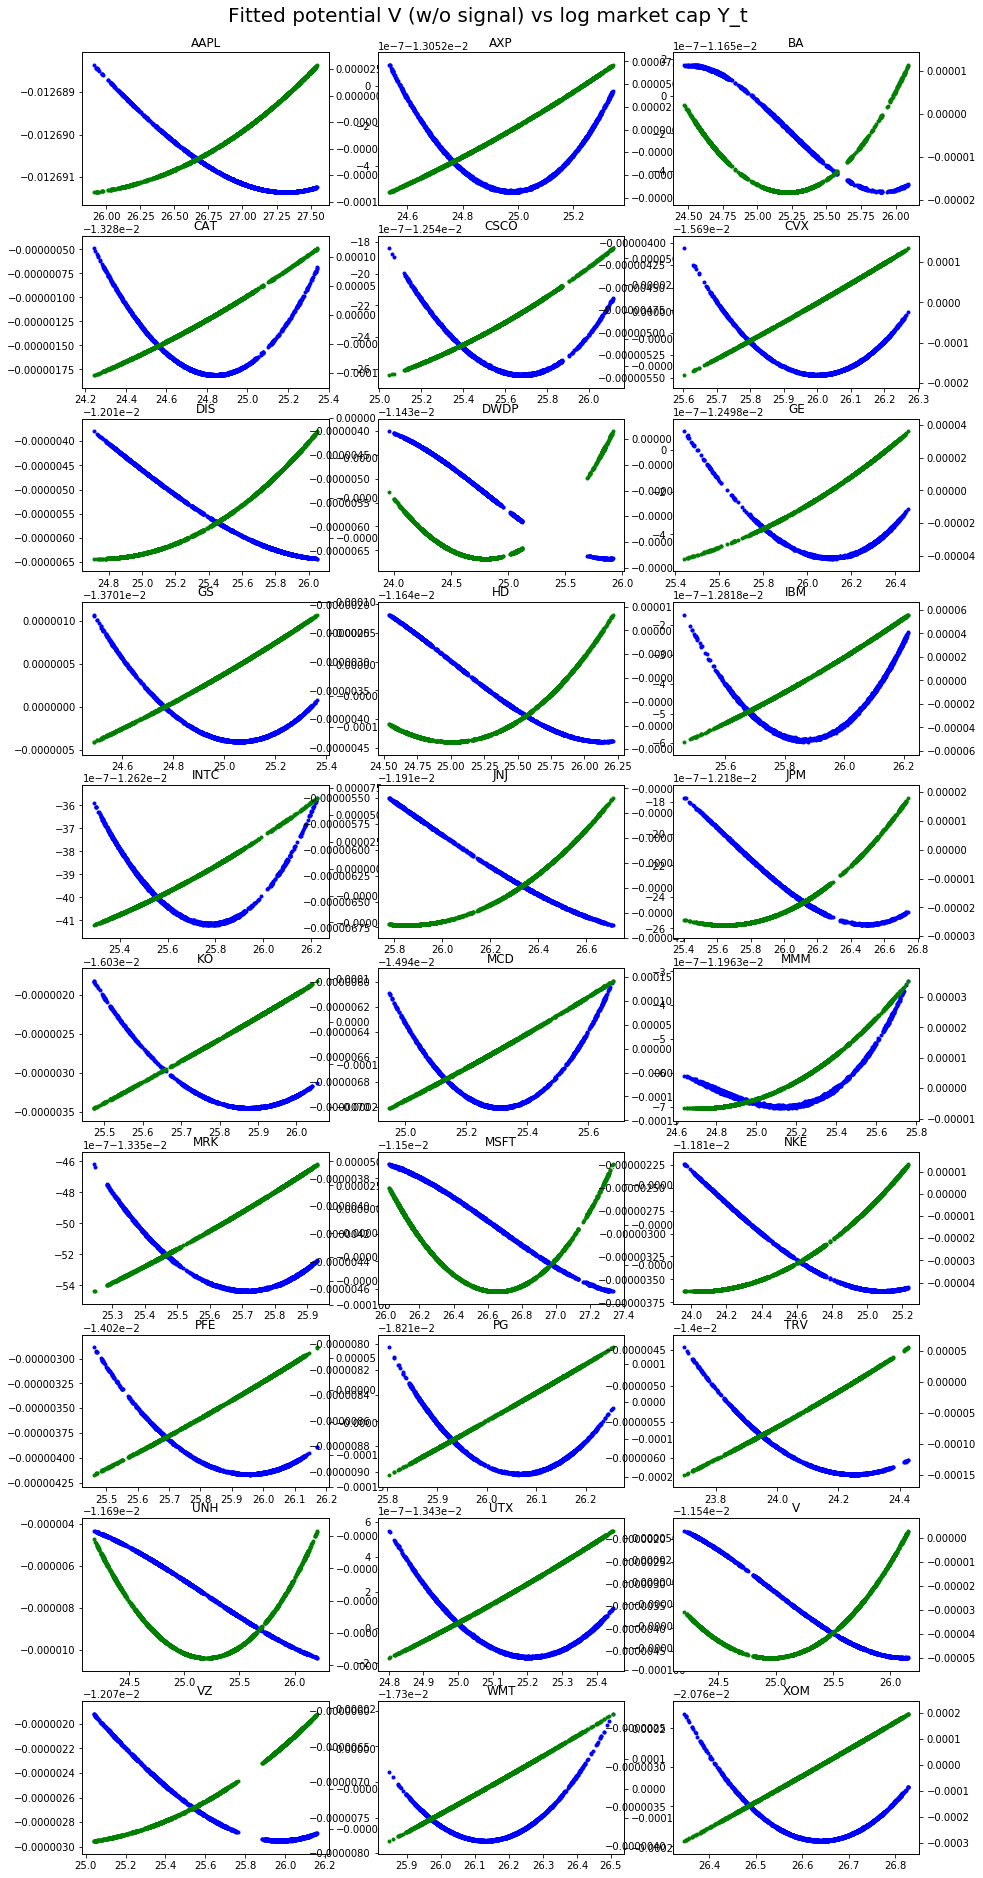

In [20]:
# Plotting fitted potential V vs log market cap Y_t

N = Y_t.shape[1]

assert N == 30

plt.figure(figsize=(15,N))
plt.suptitle('Fitted potential V (w/o signal) vs log market cap Y_t', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = Y_t.columns
for index, stock in enumerate(stocks,1):
    ax1 = plt.subplot(np.ceil(N/3),3,index)
    ax2 = ax1.twinx()
    plt.title(stock,size=12)
    ax1.plot(Y_t[stock]*average_log_market_cap[stock], df_V_1_1[stock],'b.')
    ax1.set_ylim([
        df_V_1_1[stock].min() - 0.1*(df_V_1_1[stock].max()-df_V_1_1[stock].min()), 
        df_V_1_1[stock].max() + 0.1*(df_V_1_1[stock].max()-df_V_1_1[stock].min())
    ])
    ax2.plot(Y_t[stock]*average_log_market_cap[stock], df_partial_diff_V_1_1[stock],'g.')
    ax2.set_ylim([
        df_partial_diff_V_1_1[stock].min() - 0.1*(df_partial_diff_V_1_1[stock].max()-df_partial_diff_V_1_1[stock].min()), 
        df_partial_diff_V_1_1[stock].max() + 0.1*(df_partial_diff_V_1_1[stock].max()-df_partial_diff_V_1_1[stock].min())
    ])
    #plt.xticks([])

plt.show()

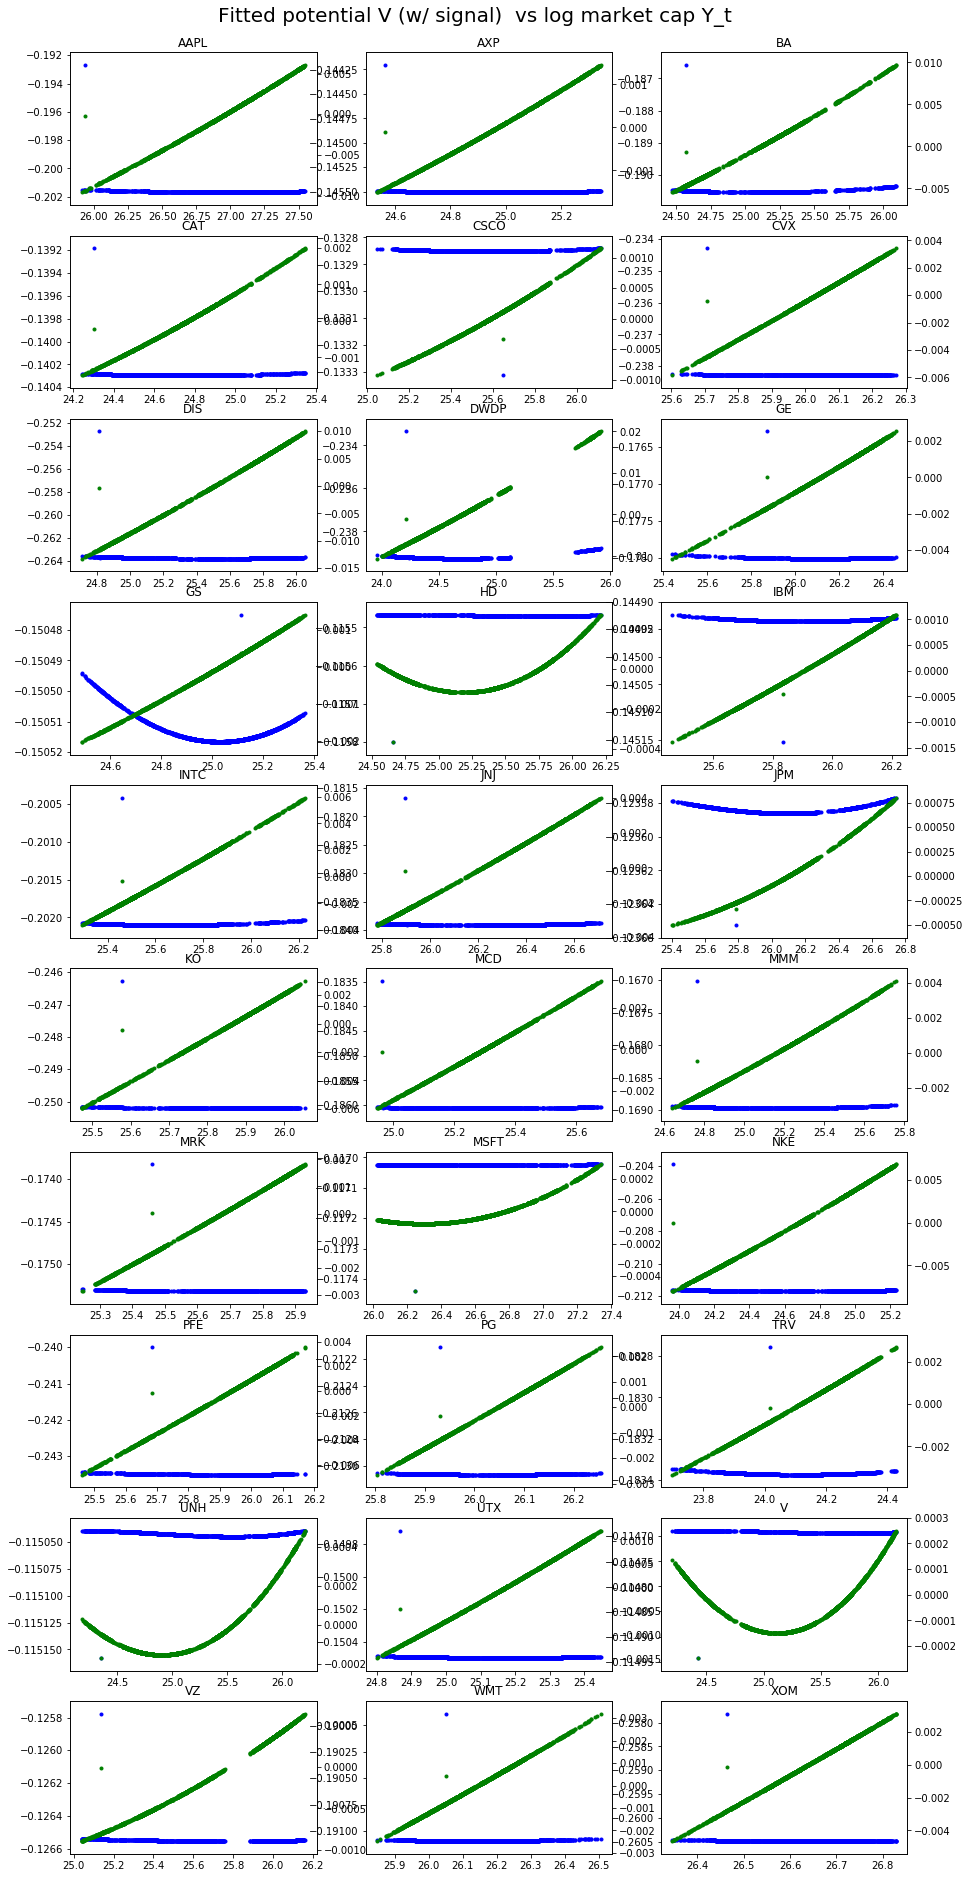

In [21]:
# Plotting fitted potential V vs log market cap Y_t

N = Y_t.shape[1]

assert N == 30

plt.figure(figsize=(15,N))
plt.suptitle('Fitted potential V (w/ signal)  vs log market cap Y_t', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = Y_t.columns
for index, stock in enumerate(stocks,1):
    ax1 = plt.subplot(np.ceil(N/3),3,index)
    ax2 = ax1.twinx()
    plt.title(stock,size=12)
    ax1.plot(Y_t[stock]*average_log_market_cap[stock], df_V_1_2[stock],'b.')
    ax1.set_ylim([
        df_V_1_2[stock].min() - 0.1*(df_V_1_2[stock].max()-df_V_1_2[stock].min()), 
        df_V_1_2[stock].max() + 0.1*(df_V_1_2[stock].max()-df_V_1_2[stock].min())
    ])
    ax2.plot(Y_t[stock]*average_log_market_cap[stock], df_partial_diff_V_1_2[stock],'g.')
    ax2.set_ylim([
        df_partial_diff_V_1_2[stock].min() - 0.1*(df_partial_diff_V_1_2[stock].max()-df_partial_diff_V_1_2[stock].min()), 
        df_partial_diff_V_1_2[stock].max() + 0.1*(df_partial_diff_V_1_2[stock].max()-df_partial_diff_V_1_2[stock].min())
    ])
    #plt.xticks([])

plt.show()

## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [22]:
# Put the rest of your code and analysis for Part 2 here.

## Considering(Single Case)

In [23]:
exp_y_1_1_b = exp_yb_1_1
exp_y_1_1_a = exp_ya_1_1

In [24]:
y_1_1_b = np.log(exp_y_1_1_b)
y_1_1_a = np.log(exp_y_1_1_a)

In [25]:
assert (y_1_1_b < y_1_1_a).all()

In [26]:
V_1_1_b = (
    -(Theta_1_1 - .5*sigma_diag_1_1**2)*y_1_1_b
    +K_1_1*exp_y_1_1_b
    +.5*G_1_1*exp_y_1_1_b**2
)
V_1_1_a = (
    -(Theta_1_1 - .5*sigma_diag_1_1**2)*y_1_1_a
    +K_1_1*exp_y_1_1_a
    +.5*G_1_1*exp_y_1_1_a**2
)

In [27]:
assert (V_1_1_b > V_1_1_a).all()

In [28]:
# Delta E = V(b) - V(a) >> .5*sigma_diag_1_1**2
assert (V_1_1_b - V_1_1_a > .5*sigma_diag_1_1**2).all()

In [29]:
partial_diff_V_1_1_b = (
    -(Theta_1_1 - .5*sigma_diag_1_1**2)
    +K_1_1*exp_y_1_1_b
    +G_1_1*exp_y_1_1_b**2
)
partial_diff_V_1_1_a = (
    -(Theta_1_1 - .5*sigma_diag_1_1**2)
    +K_1_1*exp_y_1_1_a
    +G_1_1*exp_y_1_1_a**2
)

In [30]:
assert (np.abs(partial_diff_V_1_1_b)<1e-8).all() and (np.abs(partial_diff_V_1_1_a)<1e-8).all()

In [31]:
partial_2diff_V_1_1_b = K_1_1*exp_y_1_1_b + 2*G_1_1*exp_y_1_1_b**2
partial_2diff_V_1_1_a = K_1_1*exp_y_1_1_a + 2*G_1_1*exp_y_1_1_a**2

In [32]:
assert (partial_2diff_V_1_1_b < 0).all() and (partial_2diff_V_1_1_a > 0).all()

In [33]:
r = np.sqrt(partial_2diff_V_1_1_a*np.abs(partial_2diff_V_1_1_b))/(2*np.pi) \
    * np.exp(-(2/sigma_diag_1_1**2)*(V_1_1_b - V_1_1_a))

In [34]:
annual_r = r*252.

In [35]:
series_annual_r = pd.Series(annual_r[0], index=Y_t.columns)

In [36]:
series_annual_r

AAPL    1.398027e-21
AXP     0.000000e+00
BA      1.196245e-03
CAT     0.000000e+00
CSCO    9.214021e-19
CVX     0.000000e+00
DIS     8.564520e-18
DWDP    1.568324e-04
GE      6.401343e-12
GS      0.000000e+00
HD      7.564557e-12
IBM     0.000000e+00
INTC    1.468744e-26
JNJ     4.977147e-17
JPM     1.802957e-04
KO      0.000000e+00
MCD     0.000000e+00
MMM     7.868316e-03
MRK     0.000000e+00
MSFT    6.834749e-05
NKE     4.744431e-08
PFE     0.000000e+00
PG      0.000000e+00
TRV     0.000000e+00
UNH     4.040926e-21
UTX     0.000000e+00
V       1.771403e-09
VZ      2.997548e-11
WMT     0.000000e+00
XOM     0.000000e+00
dtype: float32

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In [37]:
# Put the rest of your code and analysis for Part 3 here.

## fitting

In [38]:
AllMASignals = pd.concat([signal_log_cap_1, signal_log_cap_2, signal_log_cap_3, signal_log_cap_4], axis=1)
Z_3 = AllMASignals

In [39]:
model_3, log_LL_3, regularization_3, Theta_3, K_3, G_3, W_3, sigma_diag_3, WZ_3, V_3, partial_diff_V_3, exp_yb_3, exp_ya_3 = \
run_mle(Y_t, Y_tplus1, Z_3, learning_rate=0.0001, sameWeights=False)

    0 |         -59.3131               nan
  250 |        -111.9723          103.4307
  500 |          23.8579           76.4840
  750 |          61.2352           65.0093
 1000 |          69.0399           61.8052
 1250 |          72.5213           61.4445
 1500 |          80.7358           61.5692
 1750 |          94.6385           59.4060
 2000 |         102.0480           55.0271
 2250 |         108.6235           50.4182
 2500 |         117.8328           45.9187
 2750 |         126.7537           41.5287
 3000 |         132.4503           37.6738
 3250 |         139.9117           34.3792
 3500 |         146.7715           30.8898
 3750 |         151.3639               nan
 4000 |         156.7284               nan
 4250 |         161.1532           20.4367
 4500 |         164.1708           17.1530
 4750 |         166.5679           14.0953
 5000 |         169.1793           11.4032


## Results

In [40]:
# Fitted potential V

df_V_3 = pd.DataFrame(V_3, columns=Y_t.columns, index=Y_t.index)

In [41]:
# Fitted partial_diff_potential partial_diff_V

df_partial_diff_V_3 = pd.DataFrame(partial_diff_V_3, columns=Y_t.columns, index=Y_t.index)

## Plots

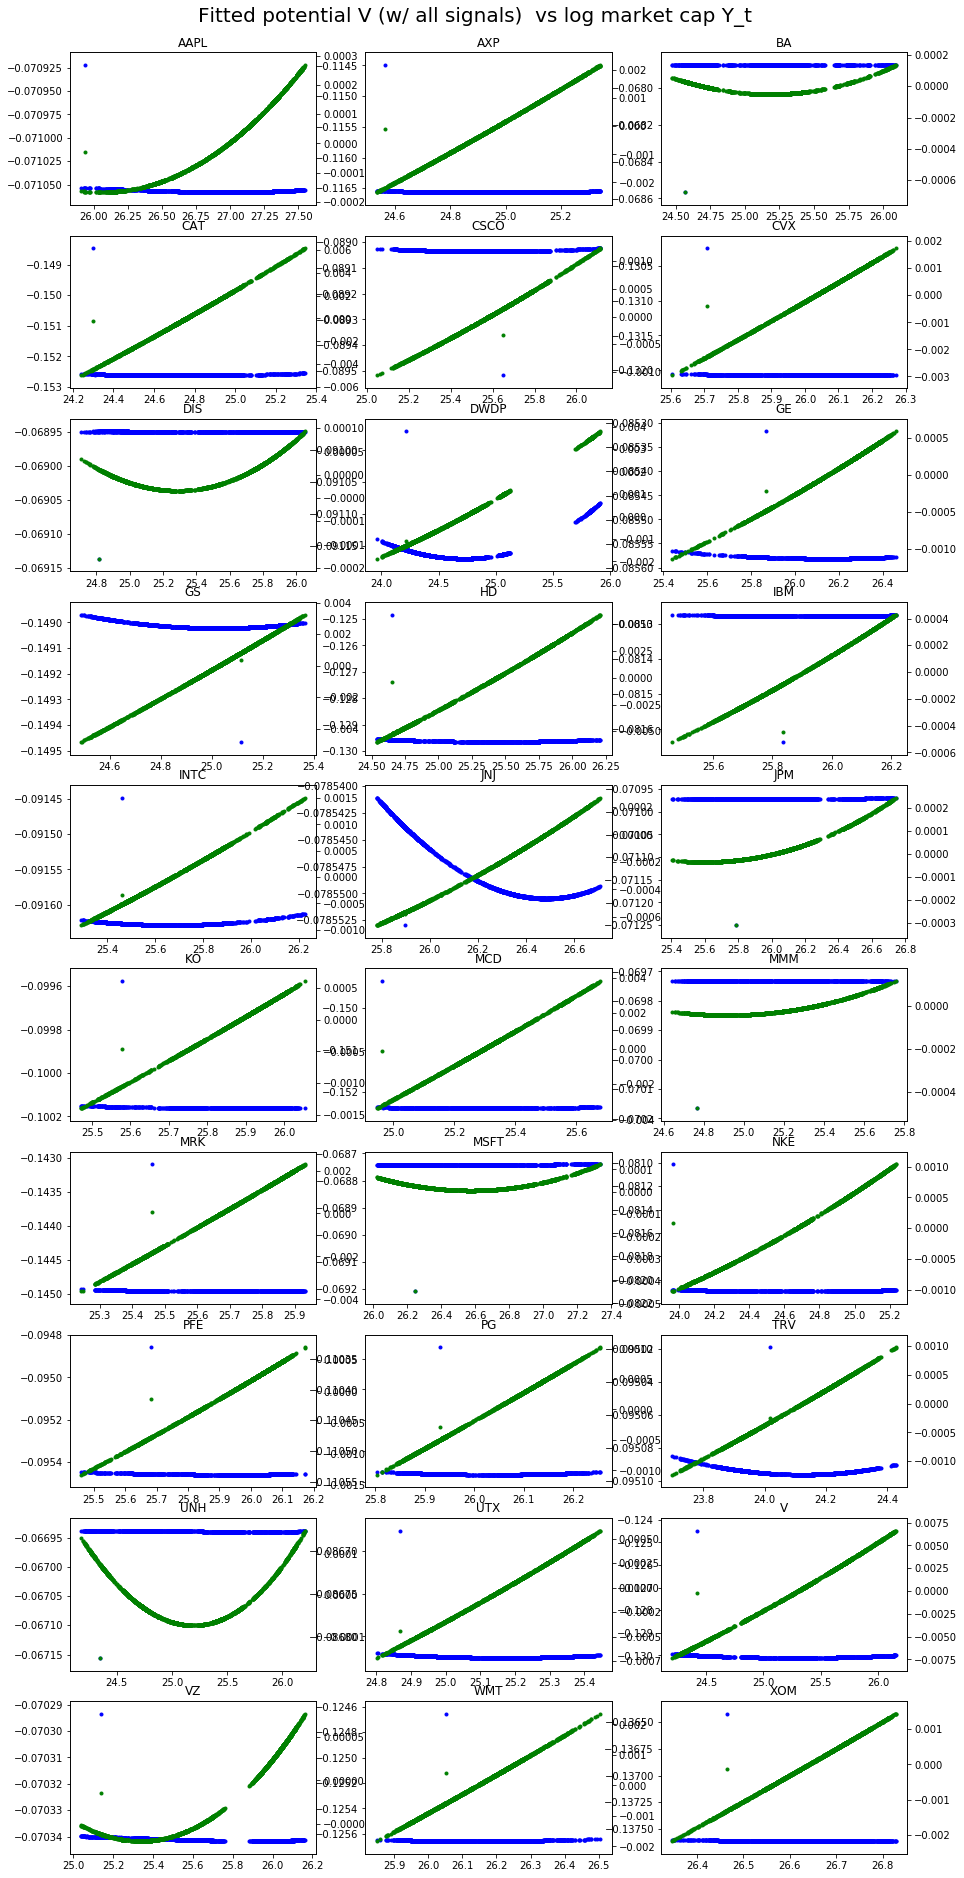

In [42]:
# Plotting fitted potential V vs log market cap Y_t

N = Y_t.shape[1]

assert N == 30

plt.figure(figsize=(15,N))
plt.suptitle('Fitted potential V (w/ all signals)  vs log market cap Y_t', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = Y_t.columns
for index, stock in enumerate(stocks,1):
    ax1 = plt.subplot(np.ceil(N/3),3,index)
    ax2 = ax1.twinx()
    plt.title(stock,size=12)
    ax1.plot(Y_t[stock]*average_log_market_cap[stock], df_V_3[stock],'b.')
    ax1.set_ylim([
        df_V_3[stock].min() - 0.1*(df_V_3[stock].max()-df_V_3[stock].min()), 
        df_V_3[stock].max() + 0.1*(df_V_3[stock].max()-df_V_3[stock].min())
    ])
    ax2.plot(Y_t[stock]*average_log_market_cap[stock], df_partial_diff_V_3[stock],'g.')
    ax2.set_ylim([
        df_partial_diff_V_3[stock].min() - 0.1*(df_partial_diff_V_3[stock].max()-df_partial_diff_V_3[stock].min()), 
        df_partial_diff_V_3[stock].max() + 0.1*(df_partial_diff_V_3[stock].max()-df_partial_diff_V_3[stock].min())
    ])
    #plt.xticks([])

plt.show()

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [43]:
# Put the rest of your code and analysis for Part 3 here.
!wget https://raw.githubusercontent.com/Paras82/ML-and-RL-in-finance/main/spx_holdings_and_spx_closeprice.csv


--2024-03-20 10:19:27--  https://raw.githubusercontent.com/Paras82/ML-and-RL-in-finance/main/spx_holdings_and_spx_closeprice.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9687131 (9.2M) [text/plain]
Saving to: ‘spx_holdings_and_spx_closeprice.csv.14’

spx_holdings_and_sp 100%[===================>]   9.24M  --.-KB/s    in 0.03s   

2024-03-20 10:19:28 (292 MB/s) - ‘spx_holdings_and_spx_closeprice.csv.14’ saved [9687131/9687131]



## Considering SPX data

In [44]:
# read the data to a Dataframe
df_spx = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()

In [45]:
df_spx.shape

(3493, 419)

In [46]:
df_spx

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,...,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,...,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,...,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,...,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,...,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12
2000-02-03,52.3856,80.9039,3.6897,4.5485,14.8807,17.2656,52.8750,10.6576,38.3165,8.2500,...,5.4939,80.6235,28.4290,11.3599,72.2265,22.7871,61.1371,19.2329,12.6375,1424.97
2000-02-04,51.3750,78.9443,3.8571,4.4727,15.4121,18.5000,55.7500,10.6576,37.8240,8.1719,...,5.6337,80.3238,28.7982,11.3051,69.8269,22.8664,62.3032,19.1345,13.2743,1424.37
2000-02-07,53.5647,76.2848,4.0737,4.4423,15.1324,19.2656,59.5000,10.6576,36.6420,9.1406,...,5.4660,80.9232,28.3367,11.2230,73.8462,22.1326,60.8039,18.7902,13.0294,1424.24
2000-02-08,53.2279,73.8353,4.1027,4.3362,15.2723,20.9375,57.3750,10.6009,36.6912,9.8750,...,5.4939,82.1220,28.1059,11.1956,74.3861,22.4103,61.1371,18.7410,13.1274,1441.72
2000-02-09,51.0381,72.3656,4.0223,4.1846,16.1394,21.8906,57.8438,10.2041,35.4600,9.5156,...,5.3541,80.6235,27.7367,11.1409,71.9865,22.0533,59.6378,18.6918,12.8090,1411.70


## Data Processing

In [47]:
# Taking logarithm of market cap values

df_log_spx = df_spx.applymap(np.log)

In [48]:
# Moving Averages

short_rolling_log_spx = df_log_spx.rolling(window=window_1).mean()
long_rolling_log_spx = df_log_spx.rolling(window=window_2).mean()

ewma_short_rolling_log_spx = df_log_spx.ewm(span=window_1, adjust=False).mean()
ewma_long_rolling_log_spx = df_log_spx.ewm(span=window_2, adjust=False).mean()

In [49]:
# Rescaling

average_log_price_spx = df_log_spx.mean(axis=0)

df_log_spx_rescaled = df_log_spx / average_log_price_spx
short_rolling_log_spx_rescaled = short_rolling_log_spx / average_log_price_spx
long_rolling_log_spx_rescaled = long_rolling_log_spx / average_log_price_spx
ewma_short_rolling_log_spx_rescaled = ewma_short_rolling_log_spx / average_log_price_spx
ewma_long_rolling_log_spx_rescaled = ewma_long_rolling_log_spx / average_log_price_spx

In [50]:
# Calculating Pct Change

short_rolling_log_spx_pct_change = short_rolling_log_spx_rescaled.pct_change(periods=1)#.shift(-1)
long_rolling_log_spx_pct_change = long_rolling_log_spx_rescaled.pct_change(periods=1)#.shift(-1)
ewma_short_rolling_log_spx_pct_change = ewma_short_rolling_log_spx_rescaled.pct_change(periods=1)#.shift(-1)
ewma_long_rolling_log_spx_pct_change = ewma_long_rolling_log_spx_rescaled.pct_change(periods=1)#.shift(-1)

In [51]:
# Market Price
log_market_price_spx = df_log_spx_rescaled.copy()
log_market_price_spx_next = df_log_spx_rescaled.shift(-1).dropna()

# Signals
signal_log_spx_1 = short_rolling_log_spx_pct_change.dropna()
signal_log_spx_2 = long_rolling_log_spx_pct_change.dropna()
signal_log_spx_3 = ewma_short_rolling_log_spx_pct_change.dropna()
signal_log_spx_4 = ewma_long_rolling_log_spx_pct_change.dropna()

# Get rid rows where dates that do not match
index3 = log_market_price_spx.index\
    .intersection(log_market_price_spx_next.index)\
    .intersection(signal_log_spx_1.index)\
    .intersection(signal_log_spx_2.index)\
    .intersection(signal_log_spx_3.index)\
    .intersection(signal_log_spx_4.index)

log_market_price_spx = log_market_price_spx.loc[index3]
log_market_price_spx_next = log_market_price_spx_next.loc[index3]
signal_log_spx_1 = signal_log_spx_1.loc[index3]
signal_log_spx_2 = signal_log_spx_2.loc[index3]
signal_log_spx_3 = signal_log_spx_3.loc[index3]
signal_log_spx_4 = signal_log_spx_4.loc[index3]

## fitting

In [52]:
Y_4_t = log_market_price_spx
Y_4_tplus1 = log_market_price_spx_next

AllMASignals_log_spx = pd.concat([signal_log_spx_1, signal_log_spx_2, signal_log_spx_3, signal_log_spx_4], axis=1)
Z_4 = AllMASignals_log_spx

In [53]:
model_4, log_LL_4, regularization_4, Theta_4, K_4, G_4, W_4, sigma_diag_4, WZ_4, V_4, partial_diff_V_4, exp_yb_4, exp_ya_4 = \
run_mle(Y_4_t, Y_4_tplus1, Z_4, learning_rate=0.0001, sameWeights=False)

    0 |        -780.0010               nan
  250 |        -515.0974           61.2989
  500 |         457.4988           44.4772
  750 |         708.3629           37.7795
 1000 |         807.9031           33.8384
 1250 |         876.4999           30.1995
 1500 |         938.9968           26.3223
 1750 |         994.6369           22.3478
 2000 |        1044.0319           18.5523
 2250 |        1088.0304           15.1777
 2500 |        1123.8693           12.3999
 2750 |        1150.0273           10.2056
 3000 |        1174.0790            8.4148
 3250 |        1194.0723            7.0093
 3500 |        1209.7028            5.8970
 3750 |        1220.8447            5.0364
 4000 |        1228.7372            4.3553
 4250 |        1234.3904            3.7814
 4500 |        1238.8585            3.3049
 4750 |        1242.9447            2.8750
 5000 |        1247.0365            2.5289


## Calibration Results

In [54]:
# Fitted potential V

df_V_4 = pd.DataFrame(V_4, columns=Y_4_t.columns, index=Y_4_t.index)

In [55]:
# Fitted partial_diff_potential partial_diff_V

df_partial_diff_V_4 = pd.DataFrame(partial_diff_V_4, columns=Y_4_t.columns, index=Y_4_t.index)

## Plotting

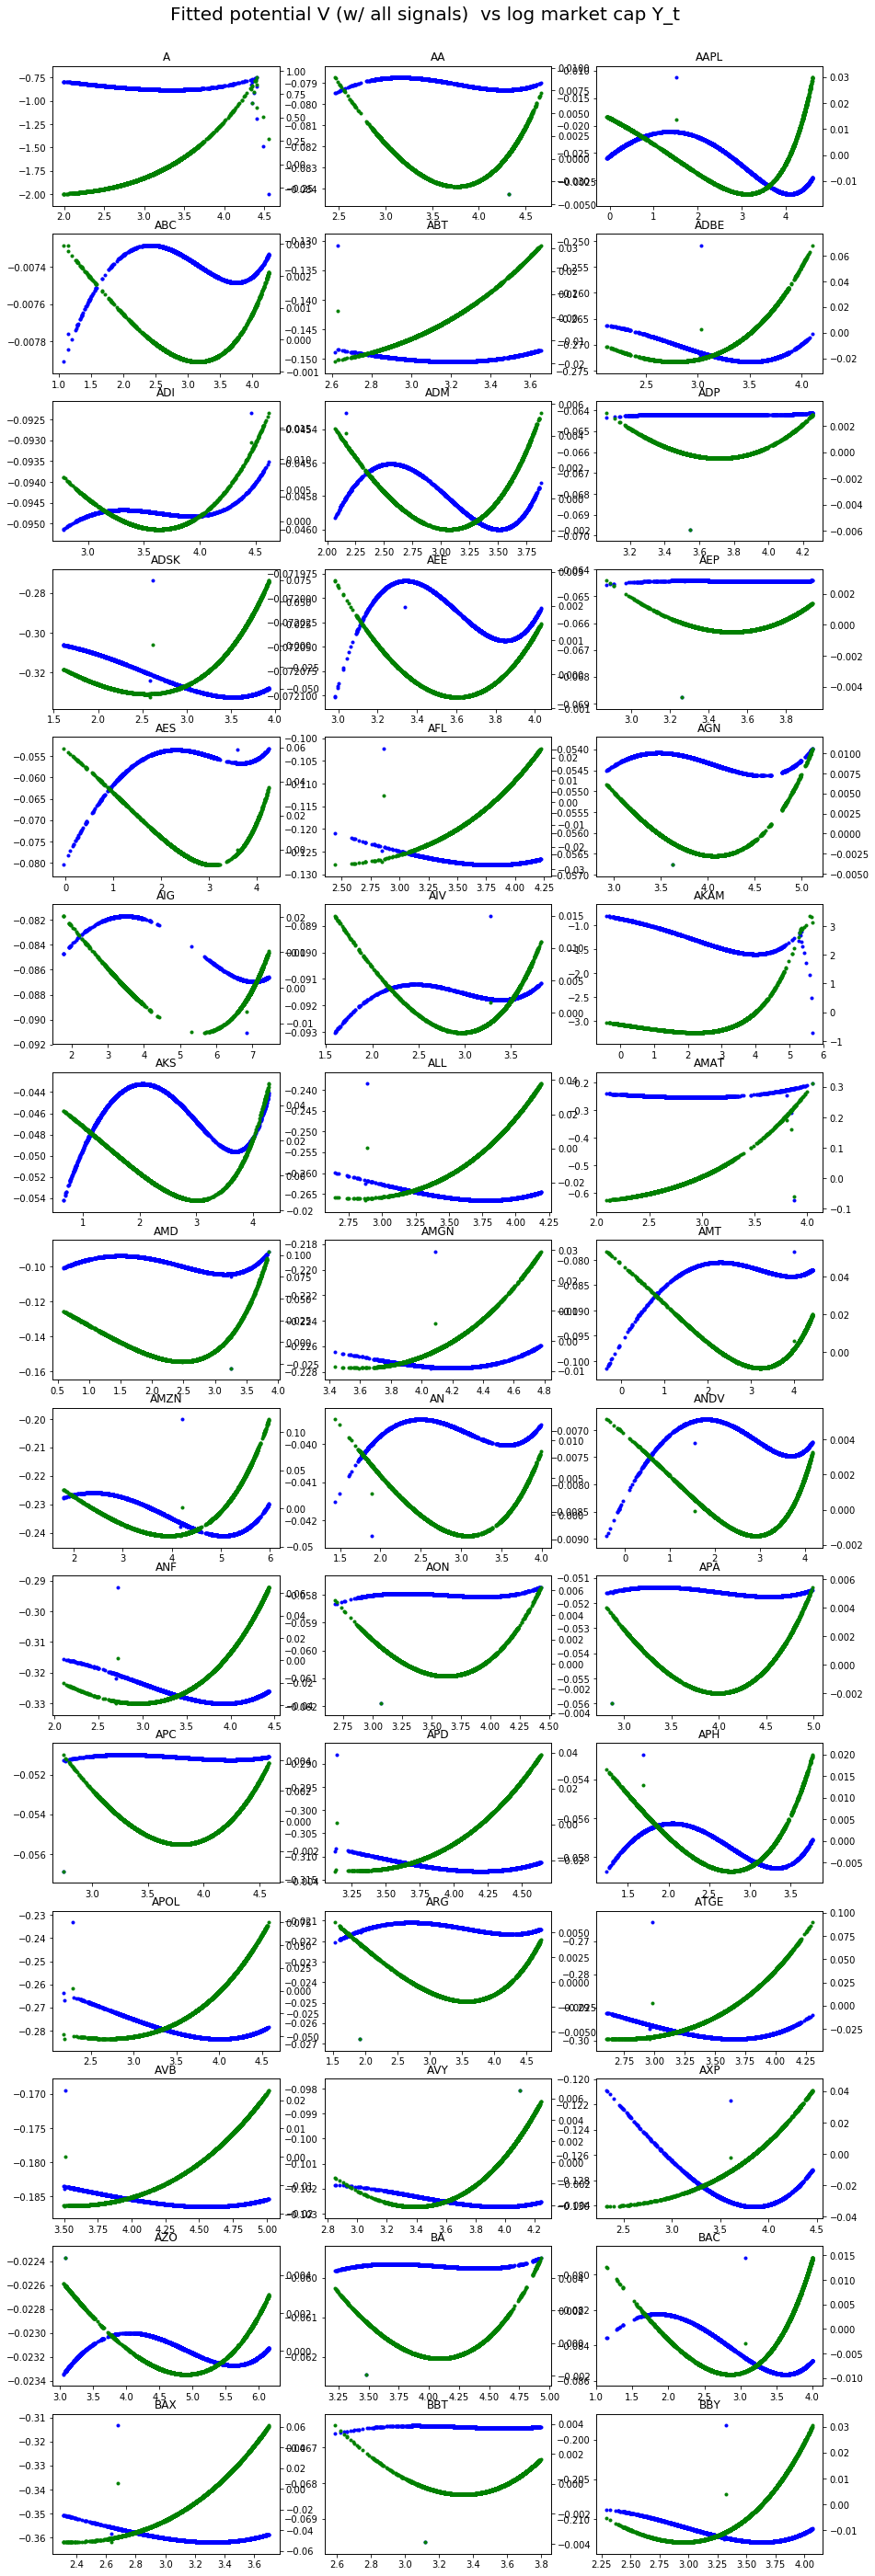

In [56]:
# Plotting fitted potential V vs log market cap Y_t

N = min( Y_4_t.shape[1], 45)

plt.figure(figsize=(15,N))
plt.suptitle('Fitted potential V (w/ all signals)  vs log market cap Y_t', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = Y_4_t.columns
for index, stock in enumerate(stocks[:N],1):
    ax1 = plt.subplot(np.ceil(N/3),3,index)
    ax2 = ax1.twinx()
    plt.title(stock,size=12)
    ax1.plot(Y_4_t[stock]*average_log_price_spx[stock], df_V_4[stock],'b.')
    ax1.set_ylim([
        df_V_4[stock].min() - 0.1*(df_V_4[stock].max()-df_V_4[stock].min()), 
        df_V_4[stock].max() + 0.1*(df_V_4[stock].max()-df_V_4[stock].min())
    ])
    ax2.plot(Y_4_t[stock]*average_log_price_spx[stock], df_partial_diff_V_4[stock],'g.')
    ax2.set_ylim([
        df_partial_diff_V_4[stock].min() - 0.1*(df_partial_diff_V_4[stock].max()-df_partial_diff_V_4[stock].min()), 
        df_partial_diff_V_4[stock].max() + 0.1*(df_partial_diff_V_4[stock].max()-df_partial_diff_V_4[stock].min())
    ])
    #plt.xticks([])

plt.show()